<a href="https://colab.research.google.com/github/Venchislav/Data-Science/blob/main/ToxicCommentsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [257]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download("stopwords")
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [258]:
# I condemn racist, sexist and other types of insults
# This data was extracted by other person
# link to dataset: https://www.kaggle.com/datasets/blackmoon/russian-language-toxic-comments
df = pd.read_csv('/content/sample_data/labeled.csv', sep=',')
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [259]:
df.shape

(14412, 2)

In [260]:
df.dtypes

comment     object
toxic      float64
dtype: object

In [261]:
df['toxic'] = df['toxic'].apply(int)
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


In [262]:
df['toxic'].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [263]:
# first five toxic comments
for comment in df[df['toxic'] == 1]['comment'].head():
  print(comment)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [264]:
# first five toxic comments
for comment in df[df['toxic'] == 0]['comment'].head():
  print(comment)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [265]:
train_df, test_df = train_test_split(df, test_size=500)

In [266]:
test_df.shape

(500, 2)

In [267]:
test_df['toxic'].value_counts()

0    320
1    180
Name: toxic, dtype: int64

In [268]:
train_df['toxic'].value_counts()

0    9266
1    4646
Name: toxic, dtype: int64

# **DATA PREPARATION**

In [269]:
sentence_ex = df.iloc[1]['comment']
tokens = word_tokenize(sentence_ex, language='russian')
tokens_no_punctuation = [i for i in tokens if i not in string.punctuation]
# no stopwords (useless words such as "a", "an", "the" etc.)
rus_stopwords = stopwords.words('russian')
tokens_no_sw_punct = [i for i in tokens_no_punctuation if i not in rus_stopwords]
# lower and no endings:
snowball = SnowballStemmer(language='russian')
stemmed_tokens = [snowball.stem(i) for i in tokens_no_sw_punct]

In [270]:
print(f'Input: {sentence_ex}\n{"-"*20}')
print(f'Tokens: {tokens}\n{"-"*20}')
print(f'Tokens no punctuation: {tokens_no_punctuation}\n{"-"*20}')
print(f'Tokens no punctuation and stopwords: {tokens_no_sw_punct}\n{"-"*20}')
print(f'Stemmed Tokens: {stemmed_tokens}\n{"-"*20}')

Input: Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

--------------------
Tokens: ['Хохлы', ',', 'это', 'отдушина', 'затюканого', 'россиянина', ',', 'мол', ',', 'вон', ',', 'а', 'у', 'хохлов', 'еще', 'хуже', '.', 'Если', 'бы', 'хохлов', 'не', 'было', ',', 'кисель', 'их', 'бы', 'придумал', '.']
--------------------
Tokens no punctuation: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'а', 'у', 'хохлов', 'еще', 'хуже', 'Если', 'бы', 'хохлов', 'не', 'было', 'кисель', 'их', 'бы', 'придумал']
--------------------
Tokens no punctuation and stopwords: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'хохлов', 'хуже', 'Если', 'хохлов', 'кисель', 'придумал']
--------------------
Stemmed Tokens: ['хохл', 'эт', 'отдушин', 'затюкан', 'россиянин', 'мол', 'вон', 'хохл', 'хуж', 'есл', 'хохл', 'кисел', 'придума']
--------------------


In [271]:
snowball = SnowballStemmer(language='russian')
rus_stopwords = stopwords.words('russian')

def tokenize_sentence(sentence: str, remove_sw: bool = True):
  tokens = word_tokenize(sentence, language='russian')
  tokens = [i for i in tokens if i not in string.punctuation]
  if remove_sw:
    tokens = [i for i in tokens if i not in rus_stopwords]
  tokens = [snowball.stem(i) for i in tokens]
  return tokens

In [272]:
tokenize_sentence(df.iloc[1]['comment'])

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

In [273]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_sw=True))

In [274]:
features = vectorizer.fit_transform(train_df['comment'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# **MODEL TRAINING**

In [275]:
model = LogisticRegression(random_state=0)

In [276]:
# features and labels
model.fit(features, train_df['toxic'])

LogisticRegression(random_state=0)

In [277]:
model.predict(features[0])

array([0])

In [278]:
train_df["comment"].iloc[0]

'Правильно понимаете. Только как правило проводникам достаётся от пассажиров за навязчивый сервис, за то что пристают с лотерейками, шоколадками не зная того что в некоторых резервах чайная продукция обратно не принимается, а выкупается проводниками за свой счёт. Чтобы у предприятия был 100 план по реализации.\n'

In [279]:
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_sw=True))),
    ("model", LogisticRegression(random_state=0))
]
)

In [280]:
model_pipeline.fit(train_df['comment'], train_df['toxic'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7cbb3ec840d0>)),
                ('model', LogisticRegression(random_state=0))])

In [281]:
model_pipeline.predict(['Привет, у меня всё хорошо'])

array([0])

In [282]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))


0.8861788617886179

In [283]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))


0.6055555555555555

In [284]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])


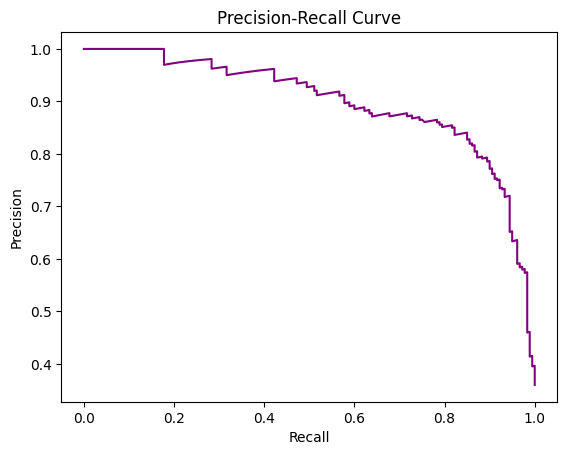

In [285]:
fig, ax = plt.subplots()
ax.plot(rec, prec, color='purple')

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')


plt.show()

In [292]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_sw=True))),
    ("model",
     GridSearchCV(
        LogisticRegression(random_state=0),
        param_grid={'C': [0.1, 1, 10.]},
        cv=3,
         verbose=4
        )
    )
])

In [293]:
grid_pipeline.fit(train_df["comment"], train_df["toxic"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.686 total time=   0.6s
[CV 2/3] END .............................C=0.1;, score=0.688 total time=   0.5s
[CV 3/3] END .............................C=0.1;, score=0.688 total time=   0.5s
[CV 1/3] END ...............................C=1;, score=0.834 total time=   0.7s
[CV 2/3] END ...............................C=1;, score=0.838 total time=   0.8s
[CV 3/3] END ...............................C=1;, score=0.841 total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3] END ............................C=10.0;, score=0.865 total time=   1.4s
[CV 2/3] END ............................C=10.0;, score=0.865 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3] END ............................C=10.0;, score=0.870 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7cbb3ec87d90>)),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=LogisticRegression(random_state=0),
                              param_grid={'C': [0.1, 1, 10.0]}, verbose=4))])

In [296]:
model_pipeline_c_10 = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_sw=True))),
    ("model", LogisticRegression(random_state=0, C=10.))
]
)


In [297]:
model_pipeline_c_10.fit(train_df["comment"], train_df["toxic"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x7cbb3ef3b640>)),
                ('model', LogisticRegression(C=10.0, random_state=0))])

In [298]:
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1])


In [299]:
np.where(prec_c_10 > 0.95)

(array([426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 447,
        448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460,
        461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473,
        474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486,
        487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498]),)

In [300]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[316])


0.8351648351648352

In [301]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[316])


0.8444444444444444